In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase import build
from ase.optimize import FIRE
from ase.io import read
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

import numpy as np
from sklearn.decomposition import PCA
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [7]:
## Set up the plotting environment
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rc('font', family='cmr10', size=12)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [8]:
## Set the plotting parameters
seed = 0
identifier1 = ""
# identifier2 = "3"
# min_energy = -3.6635127# -3.7717605425

In [9]:
## Set the descriptors
from agox.models.descriptors import SOAP, Voronoi
local_descriptor = local_descriptor = SOAP.from_species(["Si", "Ge"], r_cut=5.0)

graph_descriptor = Voronoi(
    covalent_bond_scale_factor=1.3, n_points=8, angle_from_central_atom=20, environment=None
)

In [10]:
## Set the calculators
# from chgnet.model import CHGNetCalculator
from mace.calculators import mace_mp
from ase.calculators.singlepoint import SinglePointCalculator
# calc = CHGNetCalculator()
calc = mace_mp(model="mace-mpa-0-medium.model")

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/opt/homebrew/Caskroom/miniconda/base/envs/raffle_env/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=m

In [11]:
## Load the unrelaxed structures
unrlxd_structures1 = read("DOutput"+identifier1+"/unrlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in unrlxd_structures1:
  structure.calc = calc

# ## Load the additional relaxed structures
# unrlxd_structures2 = read("DOutput"+identifier2+"/unrlxd_structures_seed"+str(seed)+".traj", index=":")


In [12]:
## Load the relaxed structures
rlxd_structures1 = read("DOutput"+identifier1+"/rlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in rlxd_structures1:
  structure.calc = calc

# ## Load the additional relaxed structures
# rlxd_structures2 = read("DOutput"+identifier2+"/rlxd_structures_seed"+str(seed)+".traj", index=":")

In [13]:
## Read energies from energies_unrlxd_seed0.txt and add to the respective structures using a SinglePointCalculator
## The file has the form "index energy"
## This is done because there seem to be issues with storing the energy in the ASE trajectory file for some setups
filename = "DOutput"+identifier1+"/energies_unrlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        unrlxd_structures1[index].calc = SinglePointCalculator(unrlxd_structures1[index], energy=energy * len(unrlxd_structures1[index]))


filename = "DOutput"+identifier1+"/energies_rlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        rlxd_structures1[index].calc = SinglePointCalculator(rlxd_structures1[index], energy=energy * len(rlxd_structures1[index]))

# filename = "DOutput"+identifier2+"/energies_unrlxd_seed"+str(seed)+".txt"
# with open(filename) as f:
#     for line in f:
#         index, energy = line.split()
#         index = int(index)
#         energy = float(energy)
#         unrlxd_structures2[index].calc = SinglePointCalculator(unrlxd_structures2[index], energy=energy * len(unrlxd_structures2[index]))


# filename = "DOutput"+identifier2+"/energies_rlxd_seed"+str(seed)+".txt"
# with open(filename) as f:
#     for line in f:
#         index, energy = line.split()
#         index = int(index)
#         energy = float(energy)
#         rlxd_structures2[index].calc = SinglePointCalculator(rlxd_structures2[index], energy=energy * len(rlxd_structures2[index]))

In [14]:
unrlxd_structures = unrlxd_structures1 #+ unrlxd_structures2
rlxd_structures = rlxd_structures1 #+ rlxd_structures2

In [15]:
## Get bulk reference energies
Si_bulk = build.bulk("Si", crystalstructure="diamond", a=5.43)
Si_bulk.calc = calc
Si_reference_energy = Si_bulk.get_potential_energy() / len(Si_bulk)
Si_cubic = build.make_supercell(Si_bulk, [[-1, 1, 1], [1, -1, 1], [1, 1, -1]])

Ge_bulk = build.bulk("Ge", crystalstructure="diamond", a=5.65)
Ge_bulk.calc = calc
Ge_reference_energy = Ge_bulk.get_potential_energy() / len(Ge_bulk)
Ge_cubic = build.make_supercell(Ge_bulk, [[-1, 1, 1], [1, -1, 1], [1, 1, -1]])


In [16]:
## Get slab energetics
Si_slab_vac = read("../Si_slab.vasp")
Ge_slab_vac = read("../Ge_slab.vasp")
Si_slab_vac.calc = calc
Ge_slab_vac.calc = calc
optimizer = FIRE(Si_slab_vac)
optimizer.run(fmax=0.05, steps=100)
optimizer = FIRE(Ge_slab_vac)
optimizer.run(fmax=0.05, steps=100)

      Step     Time          Energy          fmax
FIRE:    0 09:37:36     -404.223419        0.308327
FIRE:    1 09:37:36     -404.241852        0.287606
FIRE:    2 09:37:36     -404.272003        0.248617
FIRE:    3 09:37:37     -404.303772        0.195892
FIRE:    4 09:37:37     -404.329620        0.135901
FIRE:    5 09:37:37     -404.347687        0.144643
FIRE:    6 09:37:37     -404.362213        0.175805
FIRE:    7 09:37:38     -404.376984        0.175536
FIRE:    8 09:37:38     -404.394958        0.142853
FIRE:    9 09:37:38     -404.413055        0.100423
FIRE:   10 09:37:39     -404.429321        0.129503
FIRE:   11 09:37:39     -404.447083        0.121735
FIRE:   12 09:37:39     -404.468445        0.077042
FIRE:   13 09:37:40     -404.486176        0.055705
FIRE:   14 09:37:40     -404.490448        0.068701
FIRE:   15 09:37:40     -404.491455        0.059911
FIRE:   16 09:37:40     -404.493134        0.043550
      Step     Time          Energy          fmax
FIRE:    0 09:37

True

In [ ]:
## Get abrupt interface energetics
SiGe_abrupt = read("../SiGe_abrupt_interface.vasp")
SiGe_abrupt.calc = calc
SiGe_abrupt.set_cell(rlxd_structures[0].get_cell(), scale_atoms=True)
optimizer = FIRE(SiGe_abrupt)
optimizer.run(fmax=0.05, steps=100)

FileNotFoundError: [Errno 2] No such file or directory: 'SiGe_abrupt_interface.vasp'

In [ ]:
## Get abrupt interface area
area = np.linalg.norm(np.cross(SiGe_abrupt.get_cell()[0], SiGe_abrupt.get_cell()[1]))
print("Interface area: ", area)

Interface area:  122.76639830932618


In [ ]:
## Function to get the interface formation energy
def get_interface_energy(struc, Si_slab, Ge_slab, extra=False):
    energy = struc.get_potential_energy()
    cell = struc.get_cell()
    area = np.linalg.norm(np.cross(cell[0], cell[1]))
    Si_energy = Si_slab.get_potential_energy()
    Ge_energy = Ge_slab.get_potential_energy()
    ## need to subtract remaining silicon and germanium energies also
    if extra:
        return (energy - Si_energy - Ge_energy - 16*(Si_reference_energy + Ge_reference_energy)) / (2.0 * area)
    else:
        return (energy - Si_energy - Ge_energy) / (2.0 * area)

In [ ]:
# print("abrupt match 2 layers energy: ", get_interface_energy(abrupt, Si_slab, Ge_slab))
# print("abrupt match 3 layers energy: ", get_interface_energy(abrupt_3, Si_slab_3, Ge_slab_3))

In [ ]:
abrupt_en_per_area = get_interface_energy(SiGe_abrupt, Si_slab_vac, Ge_slab_vac, False)
print("Abrupt min energy: ", abrupt_en_per_area)

Abrupt min energy:  -0.15245676545796508


In [ ]:
## Calculate energies per atom for each unrelaxed structure
unrlxd_en_per_area = [get_interface_energy(structure, Si_slab_vac, Ge_slab_vac, False) for structure in unrlxd_structures]
print("Unrelaxed min energy: ", np.min(unrlxd_en_per_area))

Unrelaxed min energy:  0.029598842486012463


In [ ]:
## Calculate energies per atom for each relaxed structure
rlxd_en_per_area = [get_interface_energy(structure, Si_slab_vac, Ge_slab_vac, False) for structure in rlxd_structures]
print("Relaxed min energy: ", np.min(rlxd_en_per_area))

Relaxed min energy:  -0.15207966580648735


In [ ]:
## Set up the PCA
pca = PCA(n_components=2)

In [ ]:
## Get the 'super atom' descriptors for the unrelaxed structures
unrlxd_super_atoms = []
for structure in unrlxd_structures:
  unrlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [ ]:
## Get the 'super atom' descriptors for the relaxed structures
rlxd_super_atoms = []
for structure in rlxd_structures:
  rlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [ ]:
## Fit the PCA model to the unrelaxed or relaxed structures
rlxd_string = "rlxd"

In [ ]:
## Save pca model
import pickle
if True:
  pca.fit(np.squeeze([arr for arr in rlxd_super_atoms]))
  with open("pca_model_all_rlxd_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

## Load pca model
with open("pca_model_all_"+rlxd_string+"_0.pkl", "rb") as f:
  pca = pickle.load(f)

In [ ]:
abrupt_super_atom = []
abrupt_super_atom.append(np.mean(local_descriptor.get_features(SiGe_abrupt), axis=0))
abrupt_super_atom.append(np.mean(local_descriptor.get_features(SiGe_abrupt), axis=0))

In [ ]:
## Transform the unrelaxed and relaxed structures to the reduced space
unrlxd_X_reduced = pca.transform(np.squeeze([arr for arr in unrlxd_super_atoms]))
rlxd_X_reduced = pca.transform(np.squeeze([arr for arr in rlxd_super_atoms]))
abrupt_X_reduced = pca.transform(np.squeeze([arr for arr in abrupt_super_atom]))

In [ ]:
## Get the index of the structure with the minimum energy
min_energy_index = np.argmin(rlxd_en_per_area)
print(min_energy_index)

186


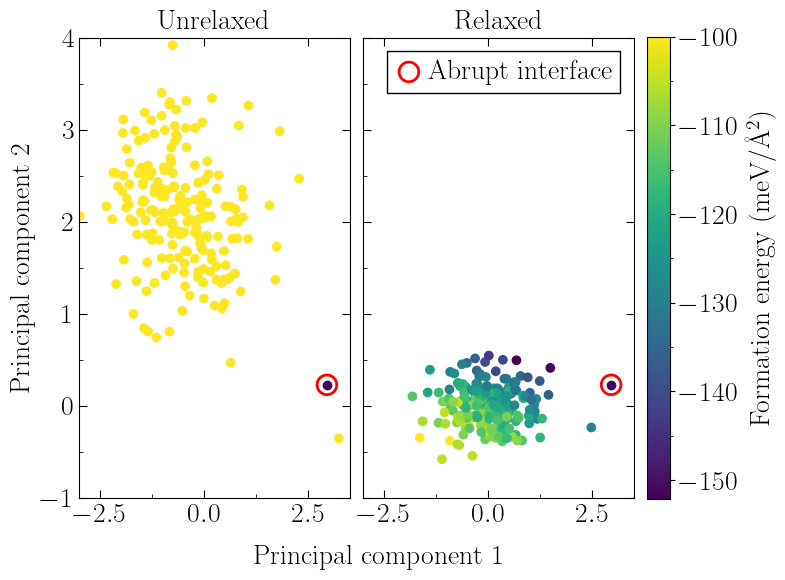

In [ ]:
## Plot the PCA
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

plt.subplots_adjust(wspace=0.05, hspace=0)

## Get the maximum energy for the colourbar
scaled_unrlxd_ens = [x * 1000 for x in unrlxd_en_per_area]
scaled_rlxd_ens = [x * 1000 for x in rlxd_en_per_area]
scaled_abrupt_en = abrupt_en_per_area * 1000
min_en = max(scaled_abrupt_en, min(np.min(scaled_unrlxd_ens), np.min(scaled_rlxd_ens)))
max_en = min(max(np.max(scaled_unrlxd_ens), np.max(scaled_rlxd_ens)), -0.1*1000)

## Plot the PCA
axes[0].scatter(unrlxd_X_reduced[:, 0], unrlxd_X_reduced[:, 1], c=scaled_unrlxd_ens, cmap="viridis", vmin = min_en, vmax = max_en)
axes[1].scatter(rlxd_X_reduced[:, 0], rlxd_X_reduced[:, 1], c=scaled_rlxd_ens, cmap="viridis", vmin = min_en, vmax = max_en)

## Add the minimum energy structures to the plot
for ax in axes:
    ax.scatter(abrupt_X_reduced[0, 0], abrupt_X_reduced[0, 1], s=200, edgecolor='red', facecolor='none', linewidth=2, label="Abrupt interface")
    ax.scatter(abrupt_X_reduced[0, 0], abrupt_X_reduced[0, 1], c=scaled_abrupt_en, cmap="viridis", vmin = min_en, vmax = max_en)
    if ax == axes[1]:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], facecolor='white', framealpha=1.0, edgecolor='black', fancybox=False, bbox_to_anchor=(1.0, 1.0), fontsize=20, handletextpad=0.2, borderpad=0.3, handlelength=1)
  
## Add labels
fig.text(0.5, 0.0, 'Principal component 1', ha='center', fontsize=20)
axes[0].set_ylabel('Principal component 2', fontsize=20)
axes[0].set_title('Unrelaxed', fontsize=20)
axes[1].set_title('Relaxed', fontsize=20)
if rlxd_string == "rlxd":
    xlims = [-3, 3.5]
    ylims = [-1, 4]
else:
    xlims = [-42, 55]
    ylims = [-12, 30]

for ax in axes:
    ax.tick_params(axis='both', direction='in', length=6, labelsize=20)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='both', which='minor', length=3, direction='in')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

## Unify tick labels
xticks = axes[0].get_xticks()
xticks = xticks[(xticks >= xlims[0]) & (xticks <= xlims[1])]

axes[1].set_xticks(xticks)
axes[1].set_yticklabels([])
axes[0].tick_params(axis='x', labelbottom=True, top=True)
axes[1].tick_params(axis='x', labelbottom=True, top=True)
axes[0].tick_params(axis='y', labelbottom=True, right=True)
axes[1].tick_params(axis='y', labelbottom=True, right=True)

## Make axes[0] and axes[1] the same width
axes[0].set_box_aspect(1.7)
axes[1].set_box_aspect(1.7)

## Add colorbar next to the axes
cbar = fig.colorbar(axes[1].collections[0], ax=axes, orientation='vertical', fraction=0.085, pad=0.02)
cbar.ax.tick_params(labelsize=20)
# cbar.ax.yaxis.set_major_locator(plt.FixedLocator([-61, -59, -57, -55, -53, -51]))
cbar.ax.yaxis.set_minor_locator(AutoMinorLocator(2))
cbar.set_label('Formation energy (meV/Å$^2$)', fontsize=20)

## Save the figure
plt.savefig('Si-Ge_RAFFLE'+identifier1+'_pca_'+rlxd_string+'_fit_seed'+str(seed)+'.pdf', bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')